# <div style="text-align: center">18.335/6.337 Problem Set 6 - Newton's Method & Eigenvalue Problem</div>
## <div style="text-align: center">Solutions</div>

### <div style="text-align: right">Creaed by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## General instructions
- Please archive all files (this Jupyter notebook plus other files if any) into a single ZIP file and upload it to the course website, so that the grader can run the Jupyter notebook in the extracted folder without adding anything.  (This greatly simplifies the grader's job.)
- Some questions may require proofs or explanations, and there are a few options to submit them electronically.
    1. Ideally, write down your proofs or explanations in the corresponding sections of this Jupyter notebook.  You can use $\LaTeX$ commands for mathematical symbols, like $A = \hat{U} \Sigma V^*$, $\sum_{j = 1}^{r} \sigma_j u_j v_j^*$, and $\left[
\begin{array}{cc}
 1 & 2 \\
 3 & 4 \\
\end{array}
\right]$.
    2. If you are not familiar with $\LaTeX$ commands, you can use any word processors with equation editors.  If you choose to use this option, make sure to convert the word processor file into PDF before submission.
    3. If none of the above works for you, you can also submit a scan of your handwritten notes as a last resort, but your handwriting must be clear and readable.
- The score of bonus problems, if any, will be added to your total problem set score at the end of the semester.  However, your total problem set score cannot exceed the perfect problem set score without bonus problems.  In other words, 
$$
\text{your total p-set score} = \min\left\{\sum_n\text{your $n$th p-set score $with$ bonus problems}, \sum_n\text{perfect $n$th p-set score $without$ bonus problems}\right\}.
$$
So solve bonus problems to compensate for the deducted points in your problem sets.

## Problem 1.  Newton's method [3 pts]

In this problem, we will implement Newton's method with the Armijo rule.

As discussed in class, for a nonlinear function $f:\Cvec{m}\rightarrow\Cvec{m}$, Newton's method finds the solution to $f(x) = 0$ by gradually updating the initial guess $x_0$ using the update equation $x_{n+1} = x_n + s_n$ for the Newton step $s_n$.  The Newton step is calculated by $s_n = \l d_n$ for the relative step size $0 < \l \le 1$ and the Newton direction

$$
d_n = -J_f(x_n)^{-1} f(x_n),
$$

where $J_f$ is the Jacobian of $f$.  The relative step size $\l$ is determined by line search, which picks $\l$ that satisfies the Armijo rule

$$
\norm{f(x_{n+1})} < (1-\alpha \l) \norm{f(x_n)}.
$$

(Note that $x_{n+1}$ depends on $\l$.)  Such $\l$ is found by repeatedly halving the initial value $\l = 1$ until the Armijo rule is met.

The stopping criterion of the Newton iteration 

$$
\norm{f(x_n)} \le \tau_\mathrm{rel} \norm{f(x_0)} + \tau_\mathrm{abs},
$$

where $\tau_\mathrm{rel}$ and $\tau_\mathrm{abs}$ are the relative and absolute tolerance, respectively.

Complete `newtsol` below that implements the above-described Newton's method.  The function takes the followings as mandatory input arguments:

- `x₀`: initial guess,
- `evalf`: function that takes $x$ as an input and returns $f(x)$ as an output, and
- `evalJ`: function that takes $x$ as an input and returns $J_f(x)$ as an output.

For the usage of `evalf` and `evalJ`, see the validation code below.

The function also takes the followings as optional keyword arguments (you don't have to know what keyword arguments are for this problem, but if interested, see [this](https://docs.julialang.org/en/stable/manual/functions/#keyword-arguments)):

- `nmax`: maximum number $n_\max$ of iteration steps,
- `τrel`: relative tolerance $\tau_\mathrm{rel}$, and
- `τabs`: absolute tolerance $\tau_\mathrm{abs}$.

The function returns the following three parameters:

- `X`: $m\times (n_\max+1)$ array whose columns store $x_0, x_1, x_2, \ldots$,
- `F`: $m\times (n_\max+1)$ array whose columns store $f(x_0), f(x_1), f(x_2), \ldots$, and
- `n`: number of stored columns in `X`.

These parameters are used to plot the trajectory of approximate solutions.

In [1]:
function newtsol(x₀, evalf, evalJ; nmax=10, τrel=sqrt(eps()), τabs=eps())
    const nmax_ls = 10   # maximum iterations inside line search
    const α = 1e-4

    m = length(x₀)
    T = eltype(x₀)

    X = zeros(T, m, nmax+1)
    F = zeros(T, m, nmax+1)

    X[:,1] = x₀
    F[:,1] = evalf(x₀)

    lf₀ = norm(F[:,1])
    const τ = τrel*lf₀ + τabs

    # Perform the Newton method.
    n = 1
    lf = lf₀
    while n ≤ nmax+1 && lf > τ
        f = @view F[:,n]
        x = @view X[:,n]

        J = evalJ(x)
      
        d = J \ f

        # Perform the line search to determine the Newton step size λ.
        λ = 1.0
        nls = 0  # line search iteration counter

        xₙ₊₁ = @view X[:,n+1]
        xₙ₊₁ .= x .- λ.*d

        fₙ₊₁ = @view F[:,n+1]
        fₙ₊₁ .= evalf(xₙ₊₁)

        lfₙ₊₁ = norm(fₙ₊₁)
        while nls ≤ nmax_ls && lfₙ₊₁ ≥ (1.0-α*λ) * lf
            λ /= 2.0
            xₙ₊₁ .= x .- λ.*d
            fₙ₊₁ .= evalf(xₙ₊₁)
            lfₙ₊₁ = norm(fₙ₊₁)
            nls += 1
        end

        # Step size calculated; continue Newton's method.
        lf = lfₙ₊₁
        n += 1
    end

    
    return X, F, n
end

newtsol (generic function with 1 method)

### Validation code 1

The following code block applies Newton's method to find the solution to $\tan^{-1}(x) = 0$ with a good guess $x_0 = 1$.

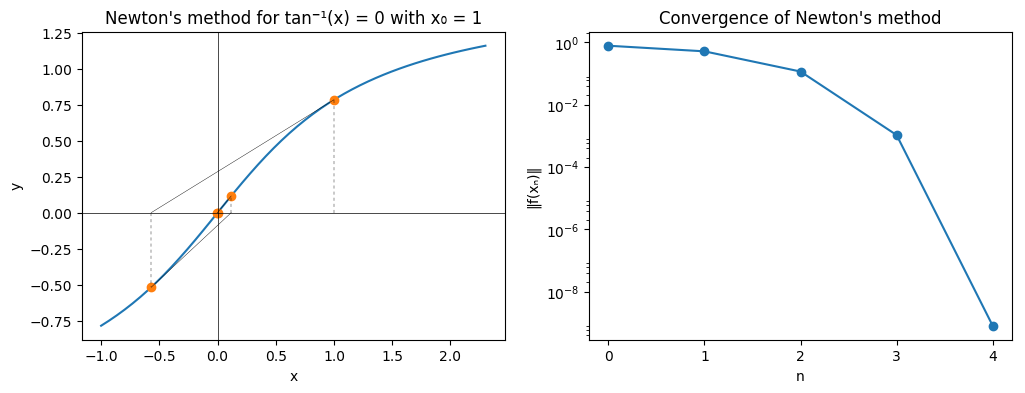

PyObject <matplotlib.text.Text object at 0x319f29da0>

In [2]:
evalf(x) = atan.(x)
evalJ(x) = 1 ./ (1 .+ x.^2)

x₀ = 1.0

X, F, n = newtsol(x₀, evalf, evalJ)

using PyPlot

figure(figsize=(12, 4))

subplot(121)
xs = linspace(-1.0, 2.3)
ys = evalf.(xs)
plot(xs, ys, "-", X[1:n], F[1:n], "o")
for k = 1:n-1
    xₖ = X[k]
    fₖ = F[k]
    Jₖ = evalJ(xₖ)
    l(x) = Jₖ * (x-xₖ) + fₖ
    xₖ₊₁ = X[k+1]
    xsₖ = linspace(xₖ₊₁, xₖ)
    plot([xₖ,xₖ], [0,fₖ], "k:", lw=0.3, xsₖ, l.(xsₖ), "k-", lw=0.3)
end
axhline(0, lw=0.5, c="k", ls="-")
axvline(0, lw=0.5, c="k", ls="-")
title("Newton's method for tan⁻¹(x) = 0 with x₀ = 1")
xlabel("x")
ylabel("y")


subplot(122)
semilogy(0:n-1, abs.(F[1:n]), "o-")
xticks(0:n-1)
title("Convergence of Newton's method")
xlabel("n")
ylabel("‖f(xₙ)‖")

### Validation code 2

The following code block solves $\tan^{-1}(x) = 0$ again, but with a bad guess $x_0 = 1$.  Line search kicks in.

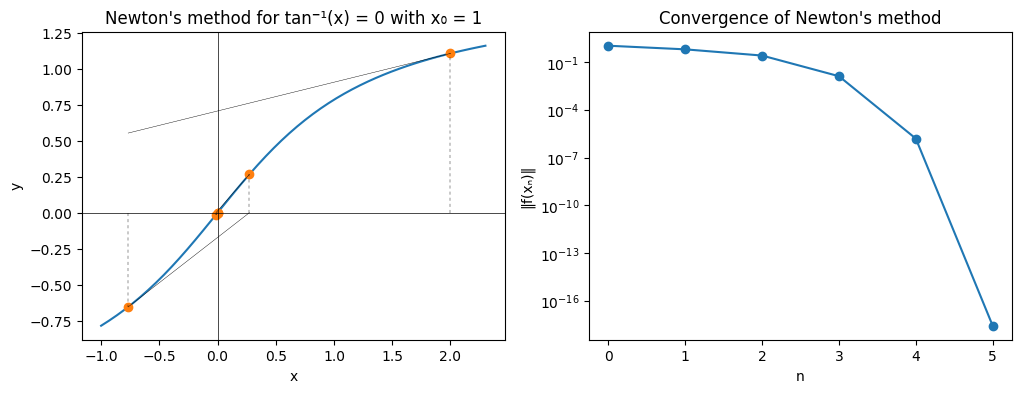

PyObject <matplotlib.text.Text object at 0x319e08390>

In [3]:
evalf(x) = atan.(x)
evalJ(x) = 1 ./ (1 .+ x.^2)

x₀ = 2.0

X, F, n = newtsol(x₀, evalf, evalJ)

using PyPlot

figure(figsize=(12, 4))

subplot(121)
xs = linspace(-1.0, 2.3)
ys = evalf.(xs)
plot(xs, ys, "-", X[1:n], F[1:n], "o")
for k = 1:n-1
    xₖ = X[k]
    fₖ = F[k]
    Jₖ = evalJ(xₖ)
    l(x) = Jₖ * (x-xₖ) + fₖ
    xₖ₊₁ = X[k+1]
    xsₖ = linspace(xₖ₊₁, xₖ)
    plot([xₖ,xₖ], [0,fₖ], "k:", lw=0.3, xsₖ, l.(xsₖ), "k-", lw=0.3)
end
axhline(0, lw=0.5, c="k", ls="-")
axvline(0, lw=0.5, c="k", ls="-")
title("Newton's method for tan⁻¹(x) = 0 with x₀ = 1")
xlabel("x")
ylabel("y")


subplot(122)
semilogy(0:n-1, abs.(F[1:n]), "o-")
xticks(0:n-1)
title("Convergence of Newton's method")
xlabel("n")
ylabel("‖f(xₙ)‖")

### Validation code 3

The following code block applies Newton's method for a 2D equation ($m = 2$).  The solution to the problem is the speed $u$ of water flow in a pipe and the Darcy friction factor $f$.  The equations and parameters are taken from [here](https://www.mathworks.com/examples/matlab/community/20292-newtonraphson_example#1).

The solution $u$ and $f$ need to be about $2.488\,\mathrm{m/s}$ and $0.02223$, respectively.

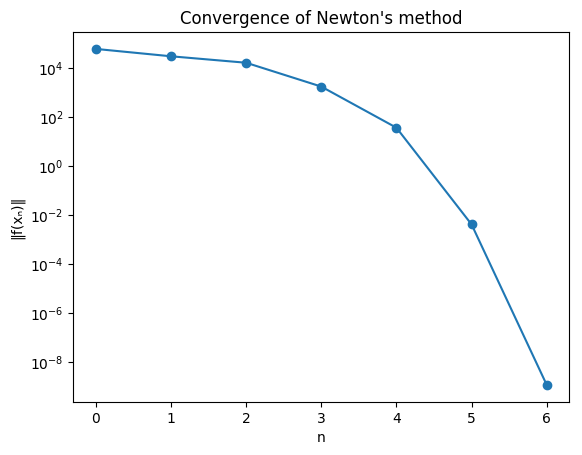

The solution is u = 2.488 m/s and f = 0.02223.

PyObject <matplotlib.text.Text object at 0x31d892518>

In [4]:
p = 0.68 # [MPa] water pressure (100 psi)
dp = -0.068*1e6 # [Pa] pipe pressure drop (10 psi)
T = 323 # [K] water temperature
D = 0.10 # [m] pipe hydraulic diameter
L = 100 # [m] pipe length
g = 0.00015 # [m] cast iron pipe roughness
rho = 988.1  # 1./IAPWS_IF97('v_pT',p,T); % [kg/m^3] water density (988.1 kg/m^3)
μ = 5.4790e-04  # IAPWS_IF97('mu_pT',p,T); % [Pa*s] water viscosity (5.4790e-04 Pa*s)
Re(u) = rho*u*D/μ # Reynolds number

# friction factor (Colebrook eqn.): residual_friction
f₁(u, f) = 1/sqrt(f) + 2*log10(g/3.7/D + 2.51/Re(u)/sqrt(f))

∂uf₁(u, f) = -2.18016μ / (D*sqrt(f)*u^2*(0.27027g/D+2.51μ/(D*sqrt(f)*u*rho))*rho)
∂ff₁(u, f) = -1.0/(2*f^(3.0/2)) - 1.09008μ/(D*f^(3.0/2)*u*(0.27027g/D+2.51μ/(D*sqrt(f)*u*rho))*rho)

# pressure drop (Darcy-Weisbach eqn.): residual_pressdrop
f₂(u, f) = rho*u^2*f*L/2/D + dp

∂uf₂(u, f) = 2rho*u*f*L/2/D
∂ff₂(u, f) = rho*u^2*L/2/D


# Define f and J.
evalf(x) = [f₁(x[1], x[2]), f₂(x[1], x[2])]
evalJ(x) = [∂uf₁(x[1],x[2]) ∂ff₁(x[1], x[2]); ∂uf₂(x[1], x[2]) ∂ff₂(x[1], x[2])]

# Apply Neweton's method.
x₀ = [1.0, 0.01]

X, F, n = newtsol(x₀, evalf, evalJ, nmax=20)

@printf "The solution is u = %.3f m/s and f = %.5f." X[1,n] X[2,n]

using PyPlot

semilogy(0:n-1, sqrt(sumabs2(F[:,1:n],1))', "o-")
xticks(0:n-1)
title("Convergence of Newton's method")
xlabel("n")
ylabel("‖f(xₙ)‖")

## Problem 2. Ancient mega structure [4 pts]

Suppose that your archeologist friend has discovered a prehistoric mega structure composed of giant stones.  The stones are scattered over several miles in a jungle, but she recognized that they are a part of a mega structure while examining aerial photos, because they are roughly placed along a perimeter of a big circle.  A natural question was what would be at the center of the circle.  

Your friend picked an estimate location of the center in the aerial photo and explored area, but could not find anything special.  She realized that even a small estimation error could make her explore a completely wrong region because the structure is so large.  So, she decided to ask you, an applied mathematician, to pinpoint the center of the structure.

She gave you the coordinates $(x_i, y_i)$ of the stones in the units of miles with respect to some origin.  The data and the scatter plot are shown below.  Your job is to develop a method to find the best estimate of the location of the center and find the estimate using the method.

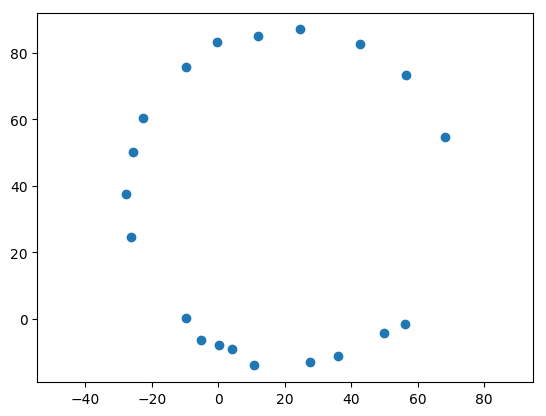

PyObject <matplotlib.collections.PathCollection object at 0x31dab79b0>

In [5]:
const xstn = [0.232448,4.27354,24.6314,-26.1335,56.5763,-9.70502,42.6852,-9.58695,35.9613,10.898,68.3313,27.5725,56.0785,-22.549,12.0429,-0.372735,-25.7023,-5.34211,49.8996,-27.8749]
const ystn = [-7.87442,-9.24168,87.0697,24.7127,73.5047,0.172235,82.818,75.7345,-11.0869,-14.0679,54.8294,-13.0876,-1.59756,60.3266,85.2028,83.404,50.0967,-6.53502,-4.14265,37.5486]
const Nstn = length(xstn)

using PyPlot

axis("equal")
scatter(xstn, ystn)

You propose the following method to estimate the center of the ancient mega structure.  Suppose the structure is a circle centered at $(\alpha, \beta)$ with radius $\rho$.  The squared "error" between a stone's location $(x_i, y_i)$ and the circle's perimeter is 

$$
g_i(\alpha, \beta, \rho) = \left[\rho -\sqrt{(\alpha-x_i)^2 + (\beta-y_i)^2}\right]^2,
$$


The least squares estimate of the circle would minimize the sum of these squared errors, i.e.

$$
g(\alpha, \beta, \rho) = \sum_{i =1}^N \left[\rho - \sqrt{(\alpha-x_i)^2 + (\beta-y_i)^2}\right]^2.
$$

Therefore, by minimizing $g$ over the three variables $\alpha$, $\beta$, and $\rho$, we can find the best estimate of the circle.

We can actually eliminate $\rho$ in this three-parameter optimization.  For given $\alpha$ and $\beta$, notice that $g$ is just a quadratic function in $\rho$.  Hence, $\rho$ that minimizes $g$ is simply

$$
\rho(\alpha, \beta) = \frac{1}{N} \sum_{k=1}^N \sqrt{(\alpha-x_k)^2 + (\beta-y_k)^2}.
$$

Hence, the objective function we want to minimize is

$$
f(\alpha, \beta) = \sum_{i =1}^N \left[\left(\frac{1}{N} \sum_{k=1}^N \sqrt{(\alpha-x_k)^2 + (\beta-y_k)^2}\right) - \sqrt{(\alpha-x_i)^2 + (\beta-y_i)^2}\right]^2.
$$

### Assignment 2.1.  Gradient and Hessian of $f$ [1pt]

The minimum point of $f(\alpha, \beta)$ can be found by Newton's method.  The goal of this assignment is to derive the gradient $\nabla f$ and Hessian $H_f$ of $f$ to use in Newton's method.  To simplify the derivation, we will define

$$
r_i(\alpha, \beta) = \sqrt{(\alpha-x_i)^2 + (\beta-y_i)^2}.
$$

Then, we have
$$
\begin{align}
\rho(\alpha, \beta) &= \frac{1}{N} \sum_{k=1}^N r_k(\alpha, \beta),\\
f_i(\alpha, \beta) &= \left[\rho(\alpha,\beta) - r_i(\alpha,\beta)\right]^2\\
f(\alpha, \beta) &= \sum_{i =1}^N f_i(\alpha, \beta).
\end{align}
$$

In other words, the objective function $f$ is written in terms of $f_i$'s, which are written in terms of $r_i$'s and $\rho$.  Here, $\rho$ is written also in terms of $r_k$.  This means that the objective function $f$ can be written in terms of $r_i$'s.  Therefore, to find the first and second derivatives of $f$ with respect to $\alpha$ and $\beta$, we only need to know the first and second derivatives of $r_i$'s with respect to $\alpha$ and $\beta$.

The first and second derivatives of $r_i$'s are derived below for you:

$$
\frac{\partial r_i}{\partial\alpha} = \frac{\alpha-x_i}{r_i}\;,\quad \frac{\partial r_i}{\partial\beta} = \frac{\beta-y_i}{r_i},\\
\frac{\partial^2 r_i}{\partial\alpha^2} = \frac{(\beta-y_i)^2}{r_i^3}\;,\quad \frac{\partial^2 r_i}{\partial\beta^2} = \frac{(\alpha-x_i)^2}{r_i^3}\;,\quad \frac{\partial^2 r_i}{\partial\alpha\partial\beta} = -\frac{(\alpha-x_i)(\beta-y_i)}{r_i^3}.
$$

The first and second derivatives of $\rho$ are simply the sum of the corresponding derivatives of $r_i$'s over $i$.

Express the first and second derivatives of $f_i$'s in terms of $\rho$, $r_i$'s, and their derivatives.

***Solution***.

$$
\begin{align}
\frac{\partial f_i}{\partial \alpha} &= 2(\rho - r_i)\left(\frac{\partial \rho}{\partial \alpha} - \frac{\partial r_i}{\partial \alpha}\right),\\
\frac{\partial f_i}{\partial \beta} &= 2(\rho - r_i)\left(\frac{\partial \rho}{\partial \beta} - \frac{\partial r_i}{\partial \beta}\right),\\
\frac{\partial^2 f_i}{\partial \alpha^2} &= 2\left(\frac{\partial \rho}{\partial \alpha} - \frac{\partial r_i}{\partial \alpha}\right)^2 + 2(\rho - r_i)\left(\frac{\partial^2 \rho}{\partial \alpha^2} - \frac{\partial^2 r_i}{\partial \alpha^2}\right),\\
\frac{\partial^2 f_i}{\partial \beta^2} &= 2\left(\frac{\partial \rho}{\partial \beta} - \frac{\partial r_i}{\partial \beta}\right)^2 + 2(\rho - r_i)\left(\frac{\partial^2 \rho}{\partial \beta^2} - \frac{\partial^2 r_i}{\partial \beta^2}\right),\\
\frac{\partial^2 f_i}{\partial \alpha \partial \beta} &= 2\left(\frac{\partial \rho}{\partial \alpha} - \frac{\partial r_i}{\partial \alpha}\right) \left(\frac{\partial \rho}{\partial \beta} - \frac{\partial r_i}{\partial \beta}\right) + 2(\rho - r_i)\left(\frac{\partial^2 \rho}{\partial \alpha\beta} - \frac{\partial^2 r_i}{\partial \alpha\beta}\right).
\end{align}
$$

###  Assignment 2.2.  Julia functions for the gradients and Hessians of $f_i$'s and $f$ [2 pts]

Using you derivation in Assignment 2.1, complete `fα`, `fβ`, `fα²`, `fβ²`, `fαβ` that calculates the first and second derivatives of $f_i$.  Then, using them, complete `eval∇f` and `evalHf` that return $\nabla f$ and $H_f$.

In [6]:
r(i, α, β) = hypot(α-xstn[i], β-ystn[i])
ρ(α, β) = mean(r.(1:Nstn, α, β))

rα(i, α, β) = (α - xstn[i]) / r(i,α,β)  # 1st derivative of rᵢ with respect to α
rβ(i, α, β) = (β - ystn[i]) / r(i,α,β)  # 1st derivative of rᵢ with respect to β
rα²(i, α, β) = (β - ystn[i])^2 / r(i,α,β)^3  # 2nd derivative of rᵢ with respect to α
rβ²(i, α, β) = (α - xstn[i])^2 / r(i,α,β)^3  # 2nd derivative of rᵢ with respect to β
rαβ(i, α, β) = -(α - xstn[i]) * (β - ystn[i]) / r(i,α,β)^3  # 2nd derivative of rᵢ with respect to α and β

ρα(α, β) = mean((α .- xstn) ./ r.(1:Nstn, α, β))  # 1st derivative of ρ with respect to α
ρβ(α, β) = mean((β .- ystn) ./ r.(1:Nstn, α, β))  # 1st derivative of ρ with respect to β
ρα²(α, β) = mean((β .- ystn).^2 ./ (r.(1:Nstn, α, β)).^3)  # 2nd derivative of ρ with respect to α
ρβ²(α, β) = mean((α .- xstn).^2 ./ (r.(1:Nstn, α, β)).^3)  # 2nd derivative of ρ with respect to β
ραβ(α, β) = -mean((α .- xstn) .* (β .- ystn) ./ (r.(1:Nstn, α, β)).^3)  # 2nd derivative of ρ with respect to α and β

fα(i, α, β) = 2(ρ(α,β) - r(i,α,β)) * (ρα(α,β) - rα(i,α,β))  # 1st derivative of fᵢ with respect to α
fβ(i, α, β) = 2(ρ(α,β) - r(i,α,β)) * (ρβ(α,β) - rβ(i,α,β))  # 1st derivative of fᵢ with respect to β
fα²(i, α, β) = 2(ρα(α,β) - rα(i,α,β))^2 + 2(ρ(α,β) - r(i,α,β)) * (ρα²(α,β) - rα²(i,α,β))  # 2nd derivative of fᵢ with respect to α
fβ²(i, α, β) = 2(ρβ(α,β) - rβ(i,α,β))^2 + 2(ρ(α,β) - r(i,α,β)) * (ρβ²(α,β) - rβ²(i,α,β))  # 2nd derivative of fᵢ with respect to β
fαβ(i, α, β) = 2(ρα(α,β) - rα(i,α,β))*(ρβ(α,β) - rβ(i,α,β)) + 2(ρ(α,β) - r(i,α,β)) * (ραβ(α,β) - rαβ(i,α,β))  # 2nd derivative of fᵢ with respect to α and β

function eval∇f(v)
    α, β = v
    
    ∇f = zeros(2)
    for i = 1:Nstn
        ∇f[1] += fα(i,α,β)
        ∇f[2] += fβ(i,α,β)
    end
    
    return ∇f
end

function evalHf(v)
    α, β = v
    
    Hf = zeros(2,2)
    for i = 1:Nstn
        Hf[1,1] += fα²(i,α,β)
        Hf[2,2] += fβ²(i,α,β)
        Hf[1,2] = Hf[2,1] += fαβ(i,α,β)
    end
    
    return Hf
end

evalHf (generic function with 1 method)

## Assignment 2.3.  Estimation of the circle center [1 pt]

Using the above implemented `eval∇f` and `evalHf`, complete the following code block that finds the least squares estimate of the center of the ancient circular mega structure.  The code block plots the circle using the estimate 

To apply Newton's method, use `newtsol` you wrote in Prob. 1.  Pick a good initial guess from the distribution of the giant stones.

If you haven't completed `newtsol` yet, you can also use the [NLsolve](https://github.com/JuliaNLSolvers/NLsolve.jl) package.  To use the package, you need to first install it by `Pkg.add("NLsolve")` and import the package by `using NLsolve`.

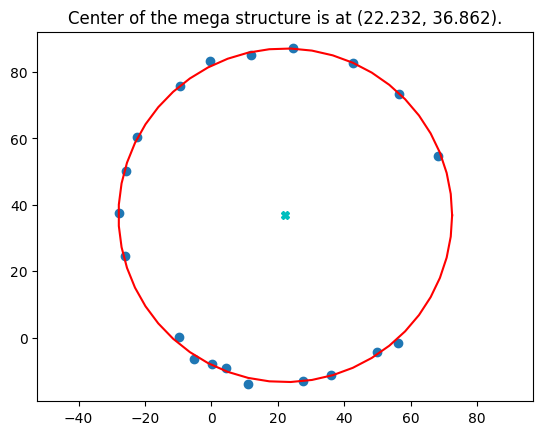

PyObject <matplotlib.text.Text object at 0x31daea9b0>

In [7]:
# Use Newton's method to minimize f.
X, F, n = newtsol([18.0, 20.0], eval∇f, evalHf)

α, β = X[:,n]

using PyPlot

axis("equal")
scatter(xstn, ystn)
θ = linspace(0, 2π)
ρsol = ρ(α, β)
plot(α.+ρsol.*cos(θ), β.+ρsol.*sin(θ), "r", α, β, "cX")
str = @sprintf "Center of the mega structure is at (%.3f, %.3f)." α β
title(str)

## Problem 3.  Rayleigh quotient iteration [3 pts]

In this problem, we will implement Rayleigh quotient iteration for eigenvalue problems $A x = λ x$.

Complete `rqi!` below that performs Rayleigh quotien iteration.  The function takes the following arguments:

- `A`: the matrix $A \in \Cmat{m}{m}$,
- `μ`: an initial guess eigenvalue $\l_0$, 
- `x`: an initial guess eigenvector $x_0$, and
- `nmax`: the maximum number $n_\max$ of iteration steps, whose default values is 10.

After execution, `x` stores the calculated eigenvector.

The function returns the following parameters:

- `λ`: a vector with $n_\max$ entries that stores the approximate eigenvalues $\l_0, \l_1, \l_2, \ldots$, and
- `n`: the index $n$ of the last calculated eigenvalue $\l_n$ ($n \le n_\max$). 

Stop Rayleigh quotient iteration 

- either when the number of iteration steps $n$ reaches $n_\max$, or 
- when $\l_n$ does not change much, i.e., $\abs{\l_{n+1} - \l_n} / \abs{\l_{n+1}} \le \tau$ for $\tau = \mathrm{eps}()$.

In [1]:
function rqi!(A, μ, x, nmax=10)
    τ = eps()

    T = eltype(x)
    λ = zeros(T, nmax+1)
    I = similar(A)
    fill!(I, 0.0)
    I[diagind(I)] = 1.0
        
    λ[1] = μ
    n = 0
    while n < nmax
        n += 1
        
        x .= (A - μ.*I) \ x
        normalize!(x)
        
        λ[n+1] = x ⋅ (A*x)
        if abs((λ[n+1] - μ) / λ[n+1]) ≤ τ
            break
        end
        μ = λ[n+1]
    end
    
    return λ, n
end

rqi! (generic function with 2 methods)

### Validation of your implementation

Use the code blocks below to validate your implementation by finding the eigenmode of the Poisson's operator (which is nothing but the negative Laplacian).

In [2]:
function poisson2d(∆x, ∆y, Nx, Ny)
    N = Nx*Ny
    ∆x⁻², ∆y⁻² = 1.0/∆x^2, 1.0/∆y^2
    row₀ = reshape(1:N, (Nx,Ny)); col₀ = row₀; val₀ = 2.0(∆x⁻² + ∆y⁻²)

    rowx₊ = row₀[1:end-1,:]; colx₊ = circshift(col₀, (-1,0))[1:end-1,:]; valx₊ = -∆x⁻²
    rowx₋ = row₀[2:end,:]; colx₋ = circshift(col₀, (1,0))[2:end,:]; valx₋ = -∆x⁻²
    rowy₊ = row₀[:,1:end-1]; coly₊ = circshift(col₀, (0,-1))[:,1:end-1]; valy₊ = -∆y⁻²
    rowy₋ = row₀[:,2:end]; coly₋ = circshift(col₀, (0,1))[:,2:end]; valy₋ = -∆y⁻²
    
    A = sparse(row₀[:], col₀[:], val₀, N, N) +
        sparse(rowx₊[:], colx₊[:], valx₊, N, N) +
        sparse(rowx₋[:], colx₋[:], valx₋, N, N) +
        sparse(rowy₊[:], coly₊[:], valy₊, N, N) +
        sparse(rowy₋[:], coly₋[:], valy₋, N, N)

    return A
end

poisson2d (generic function with 1 method)

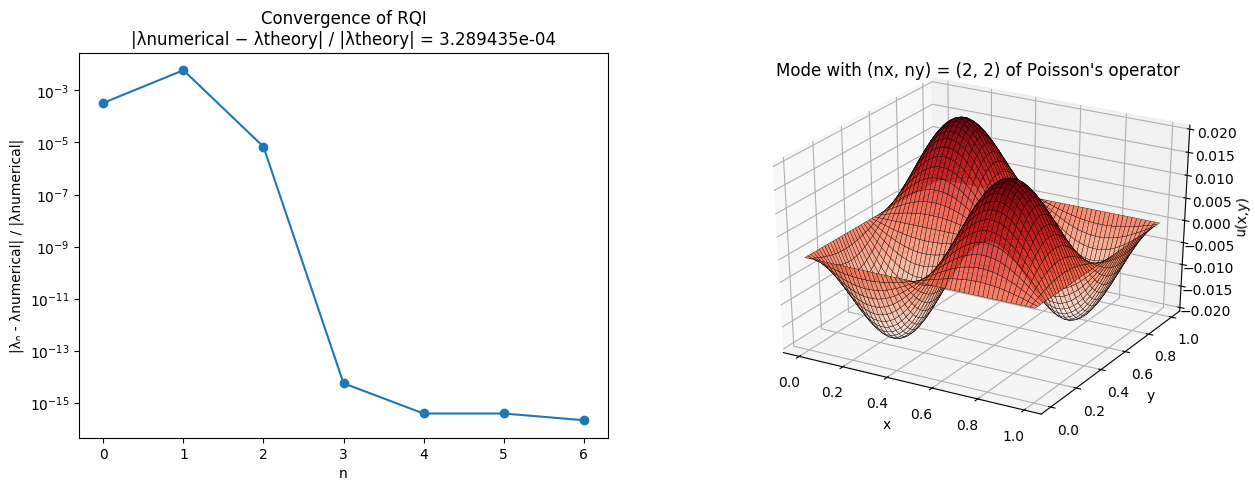

PyObject <matplotlib.text.Text object at 0x11526fac8>

In [3]:
# Choose the target mode numbers
nx, ny = 2, 2  # mode number in x and y

# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01
Lx, Ly = (Nx+1)*∆x, (Ny+1)*∆y
A = poisson2d(∆x, ∆y, Nx, Ny)

# Calculate the theoretical estimate of the eigenvalue.
λtheory = (π*nx/Lx)^2 + (π*ny/Ly)^2

# Perform Rayleigh quotient iteration to calculate the numerical eigenvalue.
x = rand(N)
λ, n = rqi!(A, λtheory, x)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] .= reshape(x, (Nx,Ny))

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

# Plot the convergence behavior and the solution.
using PyPlot

figure(figsize=(15,5))

subplot(121)
λnumerical = λ[n+1]
semilogy(0:n, abs((λ[1:n+1]-λnumerical)/λnumerical)+eps(), "o-")  # add eps() to plot error = 0.0 in log scale
err = abs((λnumerical - λtheory)/λtheory)
str = @sprintf "|λnumerical − λtheory| / |λtheory| = %e" err
title("Convergence of RQI\n$str")
xlabel("n")
ylabel("|λₙ - λnumerical| / |λnumerical|")

subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Mode with (nx, ny) = ($nx, $ny) of Poisson's operator")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

In [4]:
norm(A*x-(x⋅(A*x))*x)

6.5634342963949495e-12

In [5]:
x⋅(A*x)

78.93086286913753

## Bonus problem.  Simultaneous Rayleigh quotient iteration [3 pts]

The above implemented Rayleigh quotient iteration requires a good initial guess of the eigenvalue.  For the smallest-magnitude eigenvalue, this is not a problem because we can use $0$ as a guess.  However, for the $p$th smallest-magnitude eigenvalue, this is a serious limitation.

To overcome this limitation of Rayleigh quotient iteration, we can generalize power iteration to use more than one vector.  Suppose we have a randomly generate matrix $V \in \Cmat{m}{p}$.  If we keep multiplying $A$ to $X$ to form $A^k V$, its column space will converge to the span of $p$ eigenvectors corresponding to the $p$ largest-magnitude eigenvalues.  Therefore, the following algorithm simultaneously finds $p$ eigenvectors corresponding to the $p$ largest-magnitude eigenvalues:

```
V = random matrix with p columns
for k = 0, 1, 2, 3, ...
    V = A V
    V = orthonormal basis vectors of range(V)
end
```

(Inside the for loop, finding the orthonormal basis vectors can be done by the modified Gram–Schmidt procedure.)  This is called *simultaneous iteration*.  For the details of this idea, see the section around Eq. (28.1) in Trefethen and Bau.

By modifying `rqi!`, complete `srqi!` below that implements simultaneous Rayleigh quotient iteration, which combines simultaneous inverse iteration with Rayleigh quotient iteration.  The function takes the following arguments:

- `A`: the matrix $A \in \Cmat{m}{m}$,
- `μ`: an initial guess eigenvalue
- `X`: an $m\times p$ matrix whose columns are $p$ initial guess eigenvectors, and
- `nmax`: the maximum number $n_\max$ of iteration steps, whose default values is $5p$.

After execution, `X` stores $p$ eigenvectors corresponding to the $p$ eigenvalues closest to $\mu$.

The function returns the following parameters:

- `λ`: an $(n_\max+1)\times p$ matrix, whose each column stores the evolution of each of the $p$ eigenvalues, and
- `nconv`: a length-$p$ vector whose each entry stores the number of iteration steps until convergence of each eigenvalue.

During simultaneous inverse iteration, the eigenvector corresponding to the eigenvalue closest to `μ` converges fastest.  Once it converges, you don't have to perform simultaneous inverse iteration on the entires $p$ columns of `X`.  Record the number of iteration steps taken until this point in `nconv[1]`, and continue simultaneous inverse iteration on $p-1$ columns of `X`.  If you have convergence of another eigenvector, record the number of iteration steps taken until this point in `nconv[2]` and continue simultaneous inverse iteration on $p-2$ columns of `X`.  Repeat this until all eigenvectors converge.

**Update.** As discussed in Piazza, the technique explained above turns out to be useful only for finding the smallest-magnitude eigenvalues for Hermitian matrices, whose eigenvalues are all real.

***Solution***

When we perform QR factorization during simultaneous inverse iteration, we are not interested in the $R$ factor.  Therefore, below we implement `orthonormalize` that calculates only the $Q$ factor by MGS without storing the $R$ factor.

In [11]:
function orthonormalize!(X)
    n = size(X, 2)
    for j = 1:n
        v = @view X[:,j]
        for k = 1:j-1
            q = X[:,k]
            r = q⋅v
            v .-= r.*q
        end
        normalize!(v) 
    end
end

orthonormalize! (generic function with 1 method)

In [12]:
function srqi!(A, μ, X, nmax=5*size(X,2))
    p = size(X, 2)
    T = eltype(X)
    
    λ = zeros(T, nmax+1, p)
    I = similar(A)
    fill!(I, 0.0)
    I[diagind(I)] = 1.0
        
    λ[1,1:p] .= μ
    nconv = ones(Int64, p)
    n = 0
    k = 1
    while n < nmax
        n += 1
        nconv[k:p] .= n
        
        # Perform simultaneous inverse iteration.
        X[:,k:p] .= (A-μ.*I) \ (@view X[:,k:p])
        orthonormalize!(X)
        
        # Update approximate eigenvalues, except for the k already converged eigenvalues.
        for j = k:p
            λ[n+1,j] = X[:,j] ⋅ (A*X[:,j])
        end
        
        # If the kth eigenvalue is converged, perform inverse iteration on the (k+1)th eigenvalue from the next iteration.
        if abs((λ[n+1,k] - μ) / λ[n+1,k])  < eps()
            k == p ? break : k += 1  # move target to the next eigenvalue
        end
        μ = λ[n+1,k]
    end
    
    return λ, nconv
end

srqi! (generic function with 2 methods)

###  Validation of your implementation

Use the following code block to validate your implementation of `srqi!`.

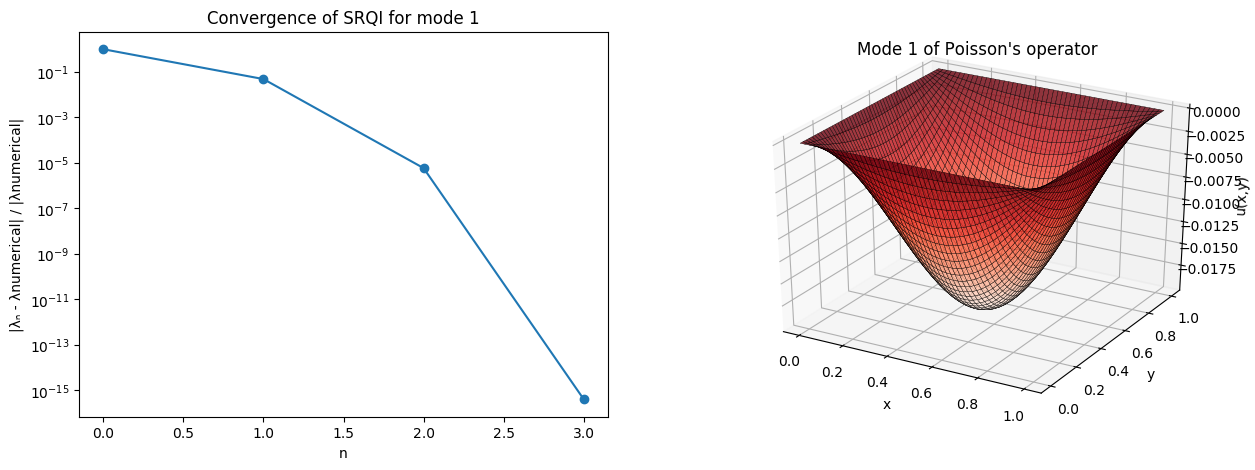

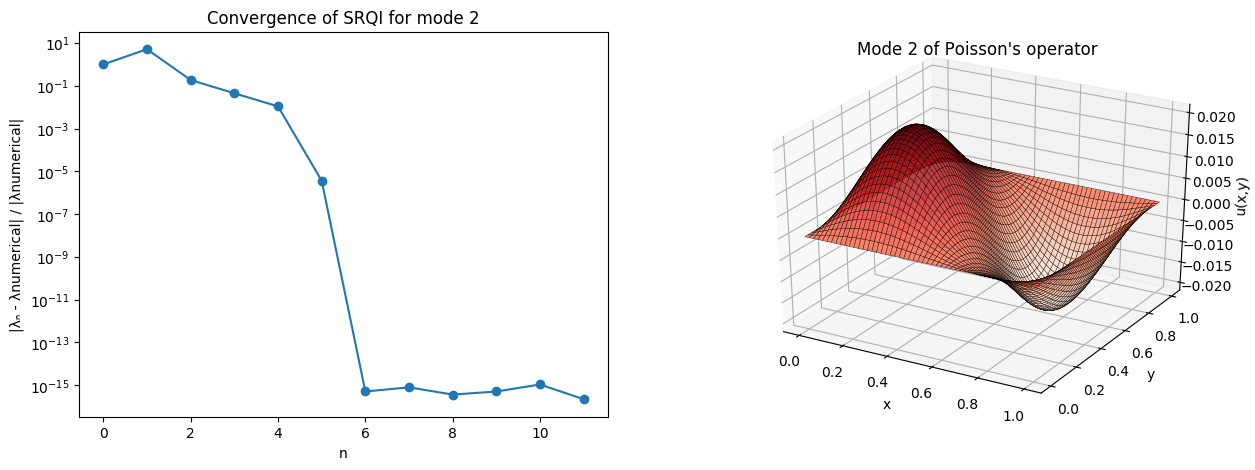

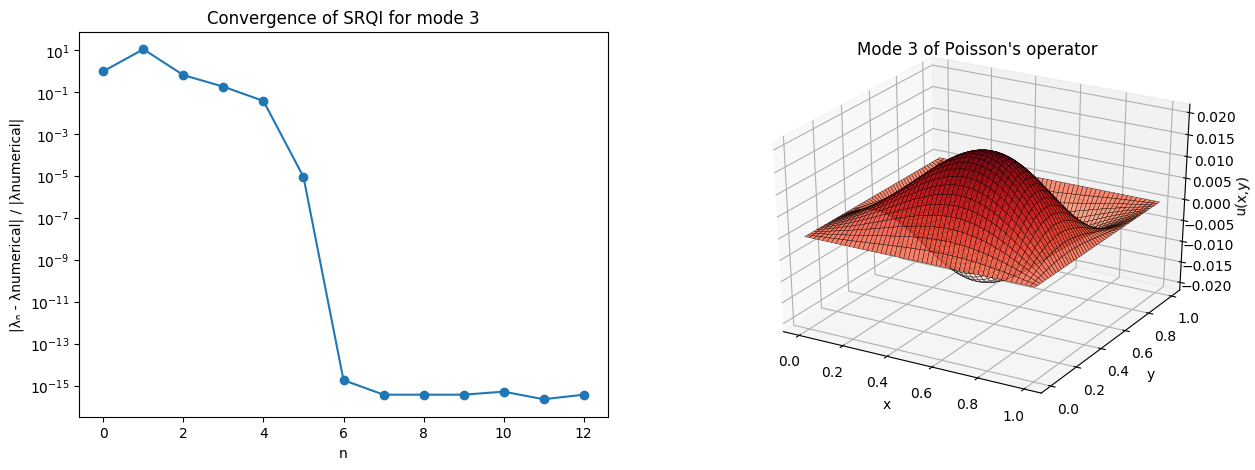

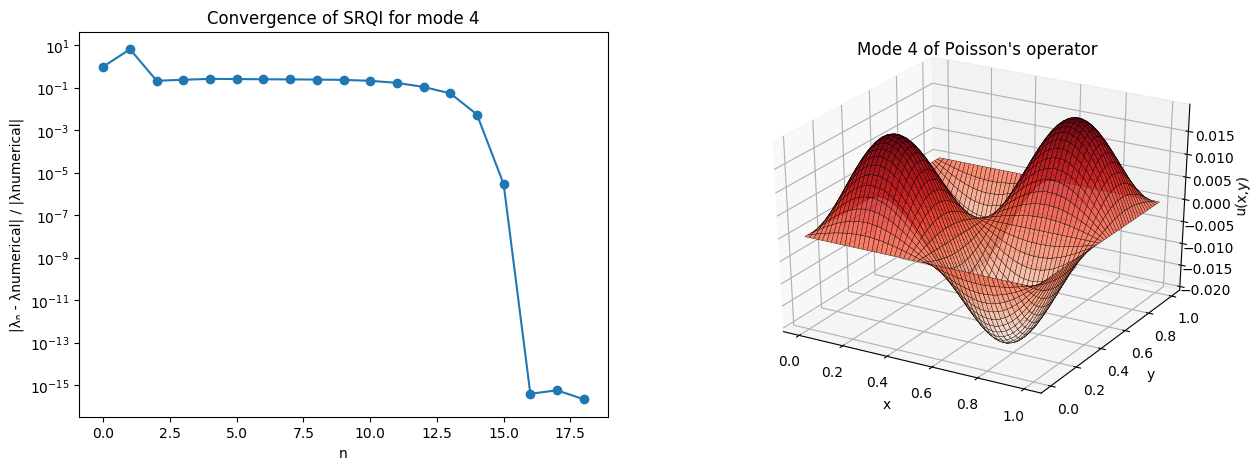

In [13]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

# Perform simultaneous Rayleigh quotient iteration to calculate p lowest energy modes of Poisson's operator.
p = 4
X = rand(N, p)
μ = 0.0
nmax = 20

λ, nconv = srqi!(A, μ, X, nmax)

# Plot the convergence behavior and the solution.
u = zeros(Nx+2, Ny+2)
using PyPlot

for k = 1:p
    # Prepare plot data.
    u[2:Nx+1, 2:Ny+1] .= reshape(X[:,k], (Nx,Ny))

    xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
    ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

    figure(figsize=(15,5))

    subplot(121)
    nₖ = nconv[k]
    λₖ = λ[nₖ+1, k]
    semilogy(0:nₖ-1, abs(λ[1:nₖ,k]-λₖ)/abs(λₖ)+eps(), "o-")
    title("Convergence of SRQI for mode $k")
    xlabel("n")
    ylabel("|λₙ - λnumerical| / |λnumerical|")


    subplot(122, projection="3d")
    plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
    title("Mode $k of Poisson's operator")
    xlabel("x")
    ylabel("y")
    zlabel("u(x,y)")
end